# Example 16: Stateful Models and TBPTT

Standard backpropagation through time (BPTT) requires storing intermediate
activations for every timestep in a sequence. For very long sequences this
quickly exhausts GPU memory. Truncated Backpropagation Through Time (TBPTT)
solves this by splitting long sequences into manageable sub-windows while
carrying the RNN hidden state across them, enabling training on arbitrarily
long sequences with bounded memory.

## Prerequisites

This example builds on concepts from Examples 00-04. Make sure you have
completed those first.

## Setup

In [1]:
from tsfast.datasets.benchmark import create_dls_silverbox
from tsfast.models.rnn import RNNLearner
from tsfast.learner.losses import fun_rmse

## The Memory Problem

When training RNNs, backpropagation stores intermediate activations for every
timestep. A sequence of length 10,000 requires roughly 100x more memory than
a sequence of length 100. For very long sequences this exceeds GPU memory.

TBPTT solves this by:

1. **Splitting** the long sequence into sub-windows (e.g., 100 timesteps each)
2. **Running** the forward pass on one sub-window at a time
3. **Computing gradients** only within each sub-window (truncated)
4. **Carrying the hidden state** from the end of one sub-window to the start
   of the next

This means the model still "sees" the full sequence through its hidden state,
but memory usage is bounded by `sub_seq_len` rather than the full sequence
length.

## Standard Training (Baseline)

First, train normally with a moderately large window to establish a reference
point. The full 500-step sequence is backpropagated through in one pass.

In [2]:
dls_standard = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10)

lrn_standard = RNNLearner(dls_standard, rnn_type='lstm', hidden_size=40, metrics=[fun_rmse])
lrn_standard.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.005680,0.005517,0.010729,00:02
1,0.004503,0.004708,0.010023,00:02
2,0.004309,0.003892,0.009725,00:02
3,0.004429,0.003618,0.009680,00:02
4,0.004123,0.003106,0.009535,00:02
5,0.004024,0.003950,0.009716,00:02
6,0.004198,0.004166,0.009763,00:02
7,0.003792,0.003921,0.009647,00:02
8,0.003144,0.003202,0.009597,00:02
9,0.002872,0.002923,0.009546,00:02


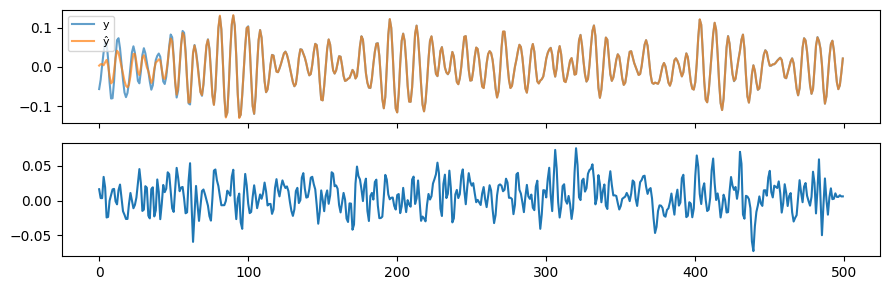

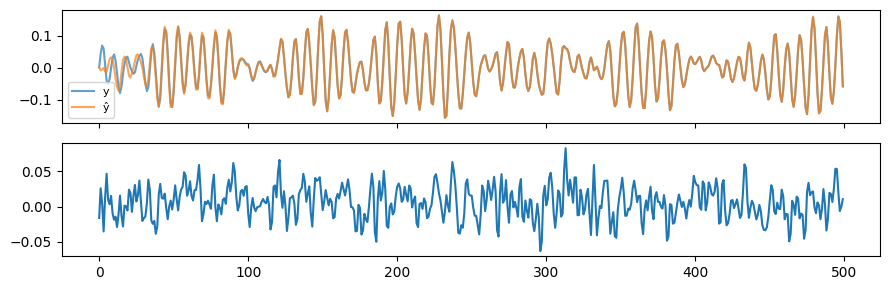

In [3]:
lrn_standard.show_results(max_n=2)

In [4]:
print(f"Standard: {lrn_standard.validate()}")

Standard: [0.0029233989771455526, 0.009546232409775257]


## TBPTT Training

Now train with TBPTT by adding `sub_seq_len` to the DataLoader creation.
This tells TSFast to split each window into sub-windows for truncated
backpropagation.

Key parameters:

- **`win_sz=500`** -- each training sample is 500 timesteps long (same as
  the baseline above).
- **`sub_seq_len=100`** -- split each 500-step window into 5 sub-windows of
  100 timesteps each.

Gradients flow through only 100 timesteps at a time (memory-efficient), but
the hidden state spans all 500 timesteps within each window. The total
sequence length `win_sz` must be divisible by `sub_seq_len`.

In [5]:
dls_tbptt = create_dls_silverbox(bs=16, win_sz=500, stp_sz=10, sub_seq_len=100)

## Stateful Model

Create a stateful RNN that maintains hidden state across sub-windows.

- **`stateful=True`** -- the RNN does **not** reset its hidden state between
  forward passes. Instead, the state from the previous sub-window initializes
  the next one. This is what allows information to flow across sub-window
  boundaries.

When `stateful=True` is set, `RNNLearner` automatically adds `TbpttResetCB`
to the learner. This callback monitors the DataLoader and resets the hidden
state whenever a new main window starts (i.e., at sequence boundaries).
Without this reset, the hidden state from one training sample would bleed
into the next, unrelated sample.

In [6]:
lrn_tbptt = RNNLearner(
    dls_tbptt, rnn_type='lstm', hidden_size=40,
    stateful=True, metrics=[fun_rmse],
)

## Train with TBPTT

Training proceeds exactly like standard training. Under the hood, the
DataLoader yields sub-windows in order, the stateful RNN carries hidden state
across them, and `TbpttResetCB` resets state at sequence boundaries.

In [7]:
lrn_tbptt.fit_flat_cos(n_epoch=10, lr=3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.010737,0.008809,0.013105,00:02
1,0.009739,0.009356,0.012440,00:02
2,0.007322,0.007155,0.010193,00:02
3,0.007341,0.008589,0.011477,00:02
4,0.006907,0.005938,0.008300,00:02
5,0.005859,0.007557,0.010508,00:02
6,0.007521,0.006745,0.009101,00:02
7,0.005886,0.004577,0.006794,00:02
8,0.004155,0.003862,0.005834,00:02
9,0.002887,0.003085,0.004980,00:02


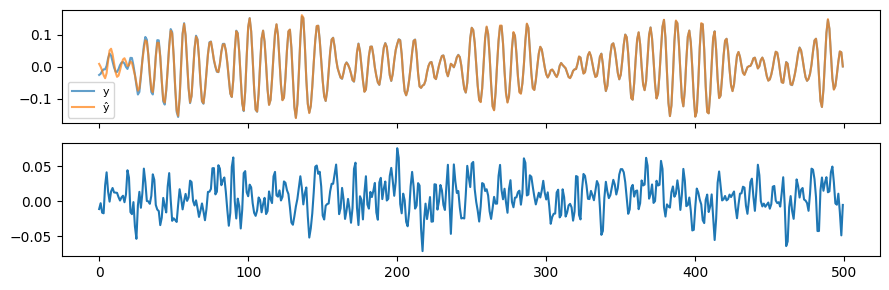

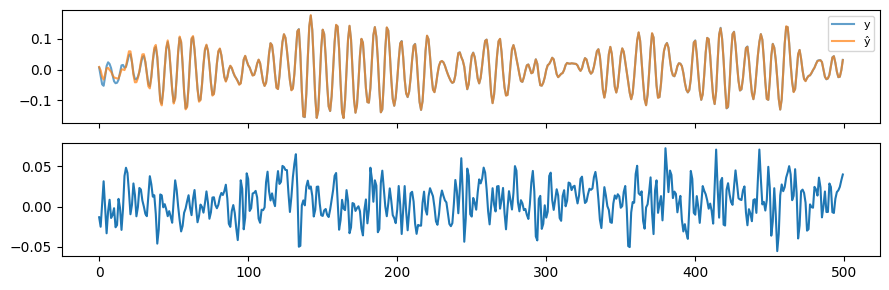

In [8]:
lrn_tbptt.show_results(max_n=2)

In [9]:
print(f"TBPTT: {lrn_tbptt.validate()}")

TBPTT: [0.003085378324612975, 0.004979943856596947]


## Comparison

Compare the final validation metrics for both approaches.

In [10]:
print(f"Standard (full BPTT):  {lrn_standard.validate()}")
print(f"Stateful (TBPTT):      {lrn_tbptt.validate()}")

Standard (full BPTT):  [0.0029233989771455526, 0.009546232409775257]


Stateful (TBPTT):      [0.003085378324612975, 0.004979943856596947]


TBPTT may have slightly different loss because gradients are truncated at
sub-window boundaries. However, performance should be comparable. The key
advantage is **memory efficiency** -- TBPTT can handle sequences that would
cause out-of-memory errors with standard training.

## When to Use TBPTT

TBPTT is most useful when:

- **Sequences are very long** (thousands of timesteps or more) and
  full backpropagation would exhaust GPU memory.
- **GPU memory is limited** and you need to keep memory usage bounded.
- **The system has long-range dependencies** that benefit from a large
  `win_sz`, but you cannot afford to backpropagate through the entire window.

For short sequences (under ~1000 timesteps), standard training is simpler and
usually sufficient. The overhead of managing sub-windows and stateful hidden
state is not worth the complexity for sequences that already fit in memory.

## Key Takeaways

- **TBPTT splits long sequences into sub-windows** with the `sub_seq_len`
  parameter on `create_dls_silverbox` (or any `create_dls` variant).
- **`stateful=True`** makes the RNN carry its hidden state across sub-windows
  instead of resetting to zero each time.
- **`TbpttResetCB`** resets hidden state at sequence boundaries so different
  training samples do not bleed into each other. It is added automatically
  when `stateful=True`.
- **Gradients are truncated** to `sub_seq_len` timesteps, bounding memory
  usage regardless of the full sequence length.
- **Hidden state spans the full sequence**, preserving long-range information
  even though gradients are truncated.
- **Use TBPTT when sequences are too long** for standard backpropagation to
  fit in GPU memory.